In [1]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 14.0 MB/s 


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.8 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 101 kB 14.8 MB/s 
     |████████████████████████████████| 6.6 MB 78.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/cs542/'

Mounted at /content/drive


Reading in the train and test files 

In [4]:
import pandas as pd

df_train = pd.read_csv(filepath+'TrainProcessed.csv')

In [5]:
df_train.Text_proc[0]

"['back', 'television', 'station', 'register', 'foreign', 'agent', 's', 'editor', 'chief', 'say', 'confirm', 'later', 'day', 'intelligence', 'agency', 'say', 'report', 'television', 'station', 'broadcast', 'cable', 's', 'state', 'run', 'propaganda', 'machine', 'contribute', 's', 'campaign', 'interfere', 'year', 's', 'presidential', 'election', 'favor', 'candidate', 'report', 'insist', 'comply', 'registration', 'requirement', 'act', 'require', 'disclose', 'financial', 'information', 'repeatedly', 'deny', 'allegation', 'election', 'meddling', 'say', 'view', 'action', 'unfriendly', 'act', 'editor', 'chief', 'say', 'comply', 'demand', 'order', 'avoid', 'legal', 'action', 'government', 'criminal', 'case', 'registration', 'choose', 'congratulate', 'american', 'freedom', 'speech', 'believe', 'say', 'confirm', 'receive', 'registration', 'operate', 'studio', 'hire', 'pay', 'employee', 'produce', 'english', 'language', 'programming', 'right', 'know', 'act', 'influence', 'government', 'public', '

In [6]:
df_test = pd.read_csv(filepath+'TestProcessed.csv')

In [7]:
#df_train_text_word_list = df_train.Text_proc

In [8]:
#df_test_text_word_list = df_test.Text_proc

In [7]:
def replace_symbols(df_list):
  updated_list = []
  for each_list in df_list:
    temp = each_list.replace(',', '')
    temp = temp.replace('[','')
    temp = temp.replace(']','')
    temp = temp.replace("'",'')
    temp = temp.replace(' s ',' ')

    updated_list.append(temp)
  return updated_list

In [8]:
df_train_text = replace_symbols(df_train.Text_proc)
df_train_title = replace_symbols(df_train.Title_proc)

In [9]:
df_train.Title_proc

0                         ['register', 'foreign', 'agent']
1              ['trump', 'pick', 'transition', 'official']
2                               ['make', 'time', 'future']
3        ['outrageous', 'report', 'spending', 'bad', 'p...
4        ['despite', 'evidence', 'say', 'stand', 'voter...
                               ...                        
40404          ['republican', 'oppose', 'tax', 'proposal']
40405    ['terror', 'attack', 'blame', 'witness', 'desc...
40406            ['hundred', 'leave', 'troop', 'rotation']
40407    ['OUCH', 'leftist', 'got', 'school', 'actor', ...
40408    ['queen', 'husband', 'celebrate', 'year', 'mar...
Name: Title_proc, Length: 40409, dtype: object

In [10]:
df_train_title[0:5]

['register foreign agent',
 'trump pick transition official',
 'make time future',
 'outrageous report spending bad pr campaign spending blow mind',
 'despite evidence say stand voter fraud belief']

In [11]:
df_test_text = replace_symbols(df_test.Text_proc)
df_test_title = replace_symbols(df_test.Title_proc)

In [12]:
df_train_label = df_train.Label.eq('T').mul(1) ##Convert T to 1 and F to 0

In [13]:
df_test_label = df_test.Label.eq('T').mul(1) ##Convert T to 1 and F to 0

In [14]:
df_test_label.head()

0    1
1    1
2    0
3    1
4    1
Name: Label, dtype: int64

In [15]:
# Get the lists of sentences and their labels.
#train_sentences = df_train_text[0:50]
#train_labels = df_train_label[0:50]
train_sentences = []
for i in range(len(df_train_text)):
  train_sentences.append(df_train_text[i] + ' ' + df_train_title[i])

In [16]:
#train_sentences = train_sentences[0:50]

In [18]:
#train_labels = df_train_label[0:50]

In [16]:
train_labels = df_train_label

In [17]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
checkpoint = 'xlm-roberta-base'
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [18]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [19]:
import torch
def process_trainingdata(tokenizer,training_set):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  token_type_ids=[]

  # For every sentence...
  for sent1 in training_set:
    encoded_dict = tokenizer(
                        sent1,
                                              # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 80,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  labels = torch.tensor(train_labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', train_sentences[0])
  print('Token IDs:', input_ids[0])

  return input_ids,attention_masks,labels

In [20]:
input_ids_bert,attention_masks_bert,labels_bert = process_trainingdata(tokenizer,train_sentences)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  back television station register foreign agent editor chief say confirm later day intelligence agency say report television station broadcast cable state run propaganda machine contribute campaign interfere year presidential election favor candidate report insist comply registration requirement act require disclose financial information repeatedly deny allegation election meddling say view action unfriendly act editor chief say comply demand order avoid legal action government criminal case registration choose congratulate american freedom speech believe say confirm receive registration operate studio hire pay employee produce english language programming right know act influence government public behalf foreign principal say act announce long allow advertisement back news organization cite intelligence television station participate effort influence election require foreign government political party lobbyist public relation firm hire register pass lead effort combat german

Splitting the train data into train and validation sets 

In [21]:
from torch.utils.data import TensorDataset, random_split

def datasetsize(input_ids, attention_masks, labels):
  dataset = TensorDataset(input_ids, attention_masks, labels)

  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size)) 
  return train_dataset,val_dataset

In [22]:
train_dataset_bert,val_dataset_bert = datasetsize(input_ids_bert,attention_masks_bert,labels_bert)

36,368 training samples
4,041 validation samples


In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
def dataloader(size,train_dataset,val_dataset):
  batch_size = size
 
  train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
  validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
  return train_dataloader, validation_dataloader

In [24]:
train_dataloader_bert, validation_dataloader_bert = dataloader(32,train_dataset_bert,val_dataset_bert)

Initializing the model for XLM Roberta Sequence Classification

In [25]:
from transformers import AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_roberta = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # need to change to the number of label in test for zero-shot performance
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model_roberta.cuda()

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [26]:
def optimizer(model):
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  return optimizer

In [27]:
optimizer_roberta = optimizer(model_roberta)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 

def scheduler(train_dataloader,optimizer):
  epochs = 4

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps) 
  return scheduler

In [30]:
scheduler_roberta = scheduler(train_dataloader_bert,optimizer_roberta)

Function to help calculate the Accuracy score

In [31]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training the dataset

In [34]:
import random
import numpy as np

def modeltraining(model,train_dataloader,validation_dataloader,optimizer,scheduler):

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  total_t0 = time.time()
  epochs = 4

  for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    torch.save(model,'/content/drive/MyDrive/cs542/xlm_models_final'+str(epoch_i)+'.pt')

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  
  return model, training_stats

In [35]:
model_roberta, training_stats = modeltraining(model_roberta,train_dataloader_bert,validation_dataloader_bert,optimizer_roberta,scheduler_roberta)


======== Epoch 1 / 4 ========
Training...
  Batch    50  of  1,137.    Elapsed: 0:00:15.
  Batch   100  of  1,137.    Elapsed: 0:00:30.
  Batch   150  of  1,137.    Elapsed: 0:00:45.
  Batch   200  of  1,137.    Elapsed: 0:00:59.
  Batch   250  of  1,137.    Elapsed: 0:01:14.
  Batch   300  of  1,137.    Elapsed: 0:01:29.
  Batch   350  of  1,137.    Elapsed: 0:01:44.
  Batch   400  of  1,137.    Elapsed: 0:01:59.
  Batch   450  of  1,137.    Elapsed: 0:02:14.
  Batch   500  of  1,137.    Elapsed: 0:02:28.
  Batch   550  of  1,137.    Elapsed: 0:02:43.
  Batch   600  of  1,137.    Elapsed: 0:02:58.
  Batch   650  of  1,137.    Elapsed: 0:03:13.
  Batch   700  of  1,137.    Elapsed: 0:03:28.
  Batch   750  of  1,137.    Elapsed: 0:03:43.
  Batch   800  of  1,137.    Elapsed: 0:03:57.
  Batch   850  of  1,137.    Elapsed: 0:04:12.
  Batch   900  of  1,137.    Elapsed: 0:04:27.
  Batch   950  of  1,137.    Elapsed: 0:04:42.
  Batch 1,000  of  1,137.    Elapsed: 0:04:57.
  Batch 1,050  of

In [36]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.23,0.12,0.96,0:05:40,0:00:11
2,0.12,0.12,0.97,0:05:40,0:00:11
3,0.07,0.12,0.97,0:05:40,0:00:11
4,0.05,0.12,0.97,0:05:40,0:00:11


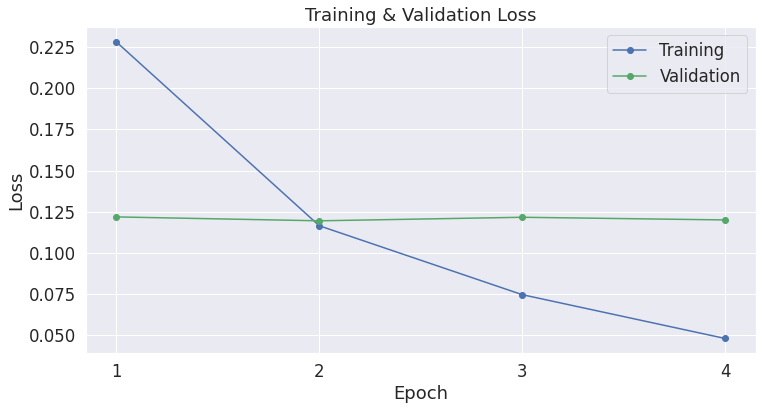

In [37]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#torch.save(model_roberta,'/content/drive/MyDrive/cs542/roberta_model1.pt')

In [38]:
#Clear CUDA cache
import gc

gc.collect()

torch.cuda.empty_cache()

Predicting on test data 

In [39]:
test_sentences = []
for i in range(len(df_test_text)):
  test_sentences.append(df_test_text[i] + ' ' + df_test_title[i])

In [40]:
test_sentences = test_sentences[0:50]

test_labels = df_test_label[0:50]

In [41]:
import pandas as pd
def test_preprocessing(tokenizer, batchsize, maxlength):
  # Load the dataset into a pandas dataframe.

   # Report the number of sentences.
  print('Number of test sentences: {:,}\n'.format(len(df_test_text)))

 
  input_ids_test = []
  attention_masks_test = []
  
  # For every sentence...
  for sent1 in test_sentences:
    encoded_dict_test = tokenizer.encode_plus(
                        sent1, # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = maxlength,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict_test['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict_test['attention_mask'])

  # Convert the lists into tensors.
  input_ids_test = torch.cat(input_ids_test, dim=0)
  attention_masks_test = torch.cat(attention_masks_test, dim=0)
  #token_type_ids_test = torch.cat(token_type_ids_test, dim=0)
  labels_rte_test = torch.tensor(test_labels)

  # Set the batch size.  
  batch_size = batchsize 

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_rte_test)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  return prediction_dataloader

In [42]:
prediction_dataloader_english_test = test_preprocessing(tokenizer,16,100)

Number of test sentences: 4,489



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
def predicttestset(model,prediction_dataloader):
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []
  total_eval_accuracy = 0
  act_pred_label = []
  act_true_labels = []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_accuracy += flat_accuracy(logits, label_ids)
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    predict_content = logits.argmax(axis=-1).flatten().tolist()
    act_pred_label += predict_content
    #print(act_pred_label)
    act_true_labels += label_ids.flatten().tolist()
  return total_eval_accuracy*100/len(prediction_dataloader), act_pred_label, act_true_labels

In [56]:
import torch

model_loaded = torch.load('/content/drive/MyDrive/cs542/xlm_models_final3.pt') ##choose based on which epoch

In [57]:
#acc_ee, pred_label_ee, true_labels_ee = predicttestset(model_roberta,prediction_dataloader_english_test) ##should be model_loaded based on which epoch
acc_ee, pred_label_ee, true_labels_ee = predicttestset(model_loaded,prediction_dataloader_english_test) ##should be model_loaded based on which epoch 

Perfomance Metrics

In [61]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [62]:
precision = precision_score(pred_label_ee, true_labels_ee)
print('Precision: %f' % precision)

Precision: 0.956522


In [64]:
f1 = f1_score(pred_label_ee, true_labels_ee)
print('F1 score: %f' % f1)

F1 score: 0.977778
